<a href="https://colab.research.google.com/github/IslamiTP/Intro-to-LLM-Homework-2/blob/main/run_ollama_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Run Ollama in Colab

### Code to initialize llama using Unsloth was retrieved from

https://colab.research.google.com/drive/1T5-zKWM_5OD21QHwXHiV9ixTRR7k3iB9?usp=sharing#scrollTo=2eSvM9zX_2d3

In [38]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git@nightly git+https://github.com/unslothai/unsloth-zoo.git

In [39]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.3.11: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [40]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 1, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [41]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.2",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

from datasets import load_dataset

# Load the full dataset
full_dataset = load_dataset("mlabonne/FineTome-100k", split="train")

# Split the dataset into training and testing sets (e.g., 80% train, 20% test)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)

# Access the train and test splits
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

Train dataset: Dataset({
    features: ['conversations', 'source', 'score'],
    num_rows: 80000
})
Test dataset: Dataset({
    features: ['conversations', 'source', 'score'],
    num_rows: 20000
})


In [57]:
from unsloth.chat_templates import standardize_sharegpt
train_dataset = standardize_sharegpt(train_dataset)
train_dataset = train_dataset.map(formatting_prompts_func, batched = True,)
test_dataset = standardize_sharegpt(test_dataset)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True,)

Unsloth: Standardizing formats (num_proc=12):   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Unsloth: Standardizing formats (num_proc=12):   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [43]:
train_dataset[5]["conversations"]

[{'content': 'How do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?',
  'role': 'user'},
 {'content': 'Astronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.',
  'role': 'assistant'}]

In [44]:
train_dataset[5]["text"]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow do astronomers determine the original wavelength of light emitted by a celestial body at rest, which is necessary for measuring its speed using the Doppler effect?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nAstronomers make use of the unique spectral fingerprints of elements found in stars. These elements emit and absorb light at specific, known wavelengths, forming an absorption spectrum. By analyzing the light received from distant stars and comparing it to the laboratory-measured spectra of these elements, astronomers can identify the shifts in these wavelengths due to the Doppler effect. The observed shift tells them the extent to which the light has been redshifted or blueshifted, thereby allowing them to calculate the speed of the star along the line of sight relative to Earth.<|

In [95]:
# Before training inference outcome from continue fibonacci sequence question.

from unsloth.chat_templates import get_chat_template
import torch

tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama-3.2",
)

messages = [
    {"role": "user", "content": "Continue the Fibonacci sequence: 1, 1, 2, 3, 5, 8,\n\n"},
]

inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,  # Must add for generation
    return_tensors="pt",
).to("cuda")

# Use torch.no_grad() for inference without locking the model
with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=2048,
        use_cache=True,
        temperature=1.5,
        min_p=0.1
    )

output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
print(output[0])

system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

Continue the Fibonacci sequence: 1, 1, 2, 3, 5, 8,

assistant

 a and, we a ( that the it or by a5 ( a a,,.

 of and for: and and: a of: is0 or5  the function,` with of by  in.4 the a.

 " for the of.. by the)4 or of =, a the),1 of a) the4 as by, the1's = for.`4's. of for a the  a function (), an as5 of,52: ( `., can  of The to  ":. the  ` are in of to for1 it`) with by number with the the, to.
 and that =4 it and and2 in..
 and in,2 "2 that we,) ( the for the function ` be the  be.
 step are ", it = that:0 and is that1  (. with ` and2  as's of for with of2 the the. that a. the is  the of a number for4 are = number with to of we the the it` are The the in5 we " = and to3 of step to:
3 an4 is with a number1 can and that the: a3 an1 a are by or is we) the and0 the be1 are.
 and's.:) The " and we `'s.

 .
 the.

: the by, and the in,.

 we and number and or the1 the and and` for. or: the  step `,  be the. in. fu

In [86]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

max_seq_length = 2048
dtype = None  # Auto detection, change if needed
load_in_4bit = False  # Set to True if using 4bit quantization

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 512,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        learning_rate = 9e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: We found double BOS tokens - we shall remove one automatically.


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/80000 [00:00<?, ? examples/s]

In [87]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map (num_proc=12):   0%|          | 0/80000 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80,000 | Num Epochs = 1 | Total steps = 78
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 512
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 512 x 1) = 1,024
 "-____-"     Trainable parameters = 1,519,616/3,214,269,440 (0.05% trained)


Step,Training Loss
1,8.494200
2,8.532200
3,8.517400
4,8.452800
5,8.439900
6,8.395100
7,8.322600
8,8.232600
9,8.282100
10,8.245700


Step,Training Loss
1,8.494200
2,8.532200
3,8.517400
4,8.452800
5,8.439900
6,8.395100
7,8.322600
8,8.232600
9,8.282100
10,8.245700


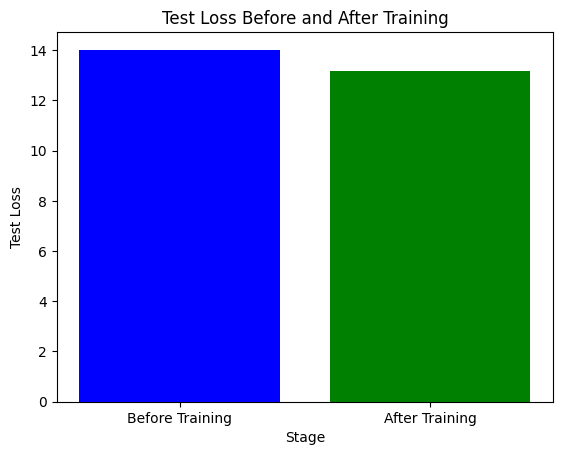

In [88]:
import matplotlib.pyplot as plt

# Assuming you already have the model, test_dataset, and trainer set up

# Calculate the test loss before training
trainer.model.eval()  # Set the model to evaluation mode
before_training_results = trainer.evaluate(test_dataset.select(range(100)))
before_training_loss = before_training_results["eval_loss"]

# Train the model
trainer.train()

# Calculate the test loss after training
trainer.model.eval()  # Set the model back to evaluation mode
after_training_results = trainer.evaluate(test_dataset.select(range(100)))
after_training_loss = after_training_results["eval_loss"]

# Prepare the data for the bar plot
losses = [before_training_loss, after_training_loss]
labels = ['Before Training', 'After Training']

# Create the bar plot
plt.bar(labels, losses, color=['blue', 'green'])
plt.xlabel('Stage')
plt.ylabel('Test Loss')
plt.title('Test Loss Before and After Training')
plt.show()

Test loss before training is 14.016039848327637
Test loss after training is 13.16002082824707


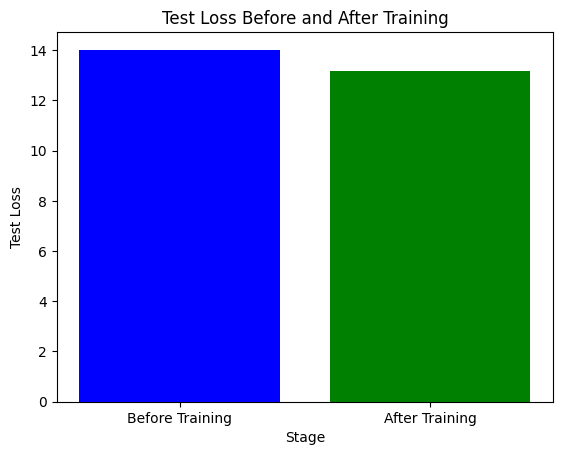

In [89]:
print("Test loss on the first 100 samples before training is", before_training_loss)
print("Test loss on the first 100 samples after training is", after_training_loss)

# Prepare the data for the bar plot
losses = [before_training_loss, after_training_loss]
labels = ['Before Training', 'After Training']

# Create the bar plot
plt.bar(labels, losses, color=['blue', 'green'])
plt.xlabel('Stage')
plt.ylabel('Test Loss')
plt.title('Test Loss Before and After Training')
plt.show()

In [94]:
# After training inference outcome from continue fibonacci sequence question.

from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.2",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8,\n\n"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = max_seq_length, use_cache = True,
                         temperature = 1.5, min_p = 0.1)

output = tokenizer.batch_decode(outputs, skip_special_tokens=True)

print(output[0])

system

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

user

What is 1 + 1assistant

 ` we,2: to a.

 and of.: the we that number The the and,'s the and to as of the3 an The5 in or the. that by and =   and function can of the,:
  in the1  to `'s. or1 " the " = are in3 to the to The step can 2 of with and be11 function function in we a The = and by number.  = =.
: is for ` with is4, and the).

, =: be  we, of The number in number.

.
 we by is are.

:  can and the.3 in. a of is,4 and step0 and.

  and 1 as. a  that`:
's and. the2 that (., is number and in  the and4 that for in of1 5, can to can.
 or of ( The by1 number:1 can the a that to number the2 `1 =1.
 can  is.

 of number the = the.,3 The of for3 and1 and3.
 for is4 can the that) number and24 or.1 in, and's step3 to2 is step. and a` the in and1 a ".1 " are it.:
 the :
 the an a in a:
1.

's of function that4 or.2 the.
2 of.
 to a function, and4 and step.5 to the for `  to that are number number that.

:
:
`:) ste

In [ ]:
# import torch
# from unsloth import FastLanguageModel
# from datasets import load_dataset
# from sentence_transformers import SentenceTransformer
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np
# from unsloth.chat_templates import get_chat_template

# test_dataset = standardize_sharegpt(test_dataset)
# test_dataset = test_dataset.map(formatting_prompts_func, batched = True)

# # Load the SentenceTransformer model for semantic similarity
# similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

# # Get the right device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move the model to the right device
# model.to(device)

# # Define a function to compute semantic similarity
# def calculate_semantic_similarity(generated_text, reference_text):
#     embeddings = similarity_model.encode([generated_text, reference_text])
#     cosine_sim = cosine_similarity([embeddings[0]], [embeddings[1]])
#     return cosine_sim[0][0]

# # Evaluate the model
# def evaluate_model_semantic_similarity(model, tokenizer, train_dataset):
#     similarities = []

#     for example in test_dataset:

#         for user, assistant in zip(example['conversations']['user'], example['conversations']['assistant']):

#           input_text = user  # Assuming 'input' field contains the text
#           expected_output = assistant  # Assuming 'output' field contains the ground truth answer

#           # Tokenize and generate the output
#           inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=max_seq_length).to(device)

#           with torch.no_grad():
#               outputs = model.generate(inputs['input_ids'], max_length=max_seq_length, temperature=0.7)

#           # Decode the generated output
#           generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

#           print(generated_text)

#           # Calculate the semantic similarity between the generated and expected output
#           similarity = calculate_semantic_similarity(generated_text, expected_output)
#           similarities.append(similarity)

#           print(similarities)

#     return similarities

# # Run evaluation
# similarities = evaluate_model_semantic_similarity(model, tokenizer, train_dataset)
# average_similarity = np.mean(similarities)
# print(f"Average Semantic Similarity: {average_similarity:.4f}")